In [1]:
import datetime as dt

import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates

In [2]:
# data
confirmed_cases = np.loadtxt('../data/confirmed_cases.dat')
recovered_cases = np.loadtxt('../data/recovered_cases.dat')
death_cases = np.loadtxt('../data/death_cases.dat')
removed_cases = recovered_cases + death_cases
active_cases = confirmed_cases - removed_cases

# 1st wave
start_date_1 = dt.datetime(2020, 2, 25)
end_date_1 = dt.datetime(2020, 6, 5)
diff = abs((end_date_1 - start_date_1).days)
removed_cases_1 = recovered_cases[:diff+1]
active_cases_1 = active_cases[:diff+1]

# 2nd wave
start_date_2 = dt.datetime(2020, 6, 6)
removed_cases_2 = removed_cases[diff+1:] - removed_cases[diff+1]
active_cases_2 = active_cases[diff+1:]

In [3]:
# utils 

def mse(y_true, y_pred):
    """Return mean square difference between two values.
    
    Parameters
    ----------
    y_true : float or numpy.ndarray
        True value(s).
        
    y_pred : float or numpy.ndarray
        Predicted or simulated value(s).
    
    Returns
    -------
    float
        Mean square error value.
    """
    return np.mean((y_true - y_pred)**2)


def train_test_split(data, split_ratio=0.8):
    """Returns data split into two parts, train and test part.
    
    Parameters
    ----------
    data : numpy.ndarray
        Full single dimensional data set.
        
    split_ratio : float, optional
        Ratio for data split.
        
    Returns
    -------
    numpy.array and numpy.array
        Train data set and test data set.
    """
    if split_ratio < 0. or split_ratio > 1.:
        raise ValueError('split_ratio ill-defined.')
    train_size = int(split_ratio * len(data))
    return data[:train_size], data[train_size:]

In [4]:
def _SEIR(t, y, beta, delta, alpha, gamma):
    """Return the SEIR compartmental system values. For details check: 
    https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology#The_SEIR_model
    
    Parameters
    ----------
    t : numpy.ndarray
        Discrete time points.
        
    y : list or tuple
        Values of S, E, I and R.
        
    beta : float
        Transition (infectious) rate controls the rate of spread. 
        
    delta : float
        Direct transition rate between S and E individual.
        
    alpha : float
        Incubation rate, the reciprocal value of the incubation period.
        
    gamma : float
        Recovery (or mortality) rate.
        
    Returns
    -------
    list
        Values of the SEIR compartmental model.
    """
    S, E, I, R = y
    N = S + E + I + R
    return [
        -beta*S*I/N - delta*S*E, 
        beta*S*I/N - alpha*E + delta*S*E, 
        alpha*E - gamma*I, 
        gamma*I,
    ]

    
def _loss(params, active_cases, removed_cases, initial_conditions):
    """Calculate and return the loss function between actual and predicted values.
    
    Parameters
    ----------
    params : list
        Values of beta, delta, alpha and gamma rates.
        
    active_cases: numpy.ndarray
        Time series of currently active infected individuals.
        
    removed_cases: numpy.ndarray
        Time series of recovered+deceased individuals.
        
    initial_conditions: list
        Values of S, E, I and R at the first day.
    
    Returns
    -------
    float
        Loss between the actual and predicted value of confirmed and recovered individuals.
    """
    size = active_cases.size
    sol = solve_ivp(
        fun=_SEIR, 
        t_span=(0, size), 
        y0=initial_conditions, 
        args=params,
        method='RK45', 
        t_eval=np.arange(0, size, 1), 
        vectorized=True,
    )
    return mse(sol.y[2], active_cases) + mse(sol.y[3], removed_cases) 


class SEIRModel(object):
    """SEIR model class."""
    def __init__(self):
        """Constructor."""
        pass

    def fit(self, active_cases, removed_cases, initial_conditions):
        """Fit SEIR model.
        
        Parameters
        ----------
        active_cases: numpy.ndarray
            Time series of currently active infected individuals.
            
        removed_cases: numpy.ndarray
            Time series of recovered+deceased individuals.
            
        initial_conditions: list
            Values of S, E, I and R at the first day.
        
        Returns
        -------
        tuple
            Fitted epidemiological parameters: beta, delta, alpha and gamma rate.
        
        list
            Loss values during the optimization procedure.
        """
        loss = []
        def print_loss(p):
            """Optimizer callback."""
            loss.append(
                _loss(p, active_cases, removed_cases, initial_conditions)
            )
            
        self.y0 = initial_conditions
        opt = minimize(
            fun=_loss, 
            x0=[0.001, 0.001, 0.001, 0.001],
            args=(active_cases, removed_cases, self.y0),
            method='L-BFGS-B',
            bounds=[(1e-5, 1.0), (1e-5, 1.0), (1e-5, 1.0), (1e-5, 1.0),],
            options={'maxiter': 1000, 'disp': True},
            callback=print_loss,
        )
        self.beta, self.delta, self.alpha, self.gamma = opt.x
        return (self.beta, self.delta, self.alpha, self.gamma), loss

    def predict(self, n_days):
        """Forecast S, E, I and R based on the fitted epidemiological parameters.
        
        Parameters
        ----------
        n_days : int
            Number of days in future.
            
        Returns
        -------
        tuple
            S, E, I and R values forecast for n_days in future.
        """
        sol = solve_ivp(
            fun=_SEIR, 
            t_span=(0, n_days), 
            y0=self.y0, 
            args=(self.beta, self.delta, self.alpha, self.gamma),
            method='RK45', 
            t_eval=np.arange(0, n_days, 1), 
            vectorized=True,
        )
        return (sol.y[0], sol.y[1], sol.y[2], sol.y[3])

In [5]:
def simulate(active_cases, removed_cases, initial_conditions, split_ratio, epidemics_start_date):
    """Plot SEIR forecast and return R0 and loss values.
    
    Parameters
    ----------
    active_cases: numpy.ndarray
        Time series of currently active infected individuals.
            
    removed_cases: numpy.ndarray
        Time series of recovered+deceased individuals.

    initial_conditions: list
        Values of S, E, I and R at the first day.
    
    split_ratio : float
        Ratio for data split.
    
    epidemics_start_date : datetime.datetime
        First day of the observed epidemic wave.
    
    Returns
    -------
    float
        Reproduction number.
        
    list
        Loss values during the optimization procedure.
    """
    train_active_cases, test_active_cases = train_test_split(active_cases, split_ratio)
    train_removed_cases, test_removed_cases = train_test_split(removed_cases, split_ratio)
    
    n_days = train_active_cases.size * 3

    seir_model = SEIRModel()
    
    (beta, delta, alpha, gamma), loss = seir_model.fit(
        train_active_cases, train_removed_cases, initial_conditions
    )
    R_eff = beta / (alpha+gamma)
    (S, E, I, R) = seir_model.predict(n_days)

    end = epidemics_start_date + dt.timedelta(days=n_days)    
    days = mdates.drange(epidemics_start_date, end, dt.timedelta(days=1))

    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111)
    _ = fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    _ = fig.gca().xaxis.set_major_locator(mdates.DayLocator(interval=20))
    ax.plot(days, S, 'k-', label='$S(t)$')
    ax.plot(days, E, 'b-', label='$E(t)$')
    ax.plot(days, I, 'r-', label='$I(t)$')
    ax.plot(days, R, 'g-', label='$R(t)$')
    ax.plot(
        days[:train_active_cases.size],
        train_active_cases, 
        linestyle='None', 
        marker='o', 
        color='red', 
        alpha=0.7, 
        label='active cases',
    )
    ax.plot(
        days[:train_removed_cases.size],
        train_removed_cases, 
        linestyle='None', 
        marker='o', 
        color='green', 
        alpha=0.7, 
        label='removed cases',
    )
    if test_active_cases.size > 0:
        ax.scatter(
            days[len(train_confirmed_cases):len(train_confirmed_cases)+len(test_confirmed_cases)],
            test_confirmed_cases,
            facecolors='none', 
            edgecolors='r', 
            linestyle='None',
            label='test infected',
        )
        ax.scatter(
            days[len(train_recovered_cases):len(train_recovered_cases)+len(test_recovered_cases)],
            test_recovered_cases,
            facecolors='none', 
            edgecolors='g', 
            linestyle='None',
            label='test removed',
        )
        plt.axis([mdates.date2num(epidemics_start_date - dt.timedelta(days=1)), days[active_cases.size + 1], -100, 1750])
        _ = fig.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))
        plt.legend(loc='best')
    else:
        plt.legend(loc='lower right')
    _ = plt.gcf().autofmt_xdate()
    plt.ylabel('$N$')
    plt.grid()
    plt.show()
    return R_eff, loss

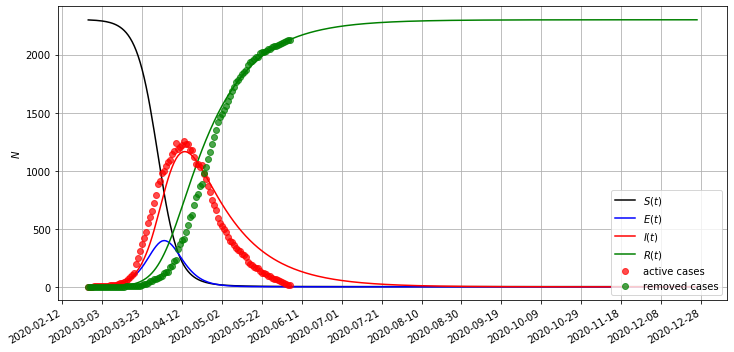

In [6]:
S0 = 2300
E0 = 1
I0 = active_cases_1[0]
R0 = removed_cases_1[0]

R_eff, loss = simulate(
    active_cases=active_cases_1, 
    removed_cases=removed_cases_1, 
    initial_conditions=(S0, E0, I0, R0),
    split_ratio=1.,
    epidemics_start_date=start_date_1,
)

In [7]:
R_eff

0.9969530352775519

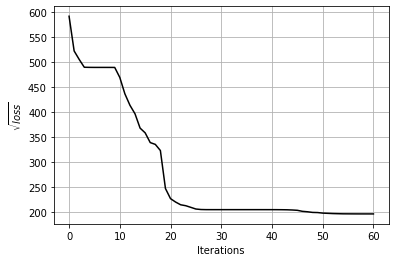

In [8]:
plt.plot(np.sqrt(loss), 'k-')
plt.xlabel('Iterations')
plt.ylabel(r'$\sqrt{loss}$')
plt.grid()
plt.show()